In [28]:
# GPU 디바이스 정보 확인
!nvidia-smi

!lspci

Thu Dec  5 23:36:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 560.94       CUDA Version: 12.6     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   33C    P8              18W / 290W |   7822MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [29]:
import tensorflow as tf
import keras as keras

# GPU가 사용 가능한지 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# GPU 메모리 제한 설정 예시
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if gpus:
  try:
    # 첫 번째 GPU에 대해 1GB 메모리만 할당
    tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

%reset -f


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPU, 1 Logical GPU


In [30]:
import numpy as np
import pandas as pd

# 1) 데이터 읽기
file_path_usd = 'data/btc_usd_with_trend_sorted.csv'
file_path_krw = 'data/btc_krw_with_trend_sorted.csv'

df_usd = pd.read_csv(file_path_usd)
df_krw = pd.read_csv(file_path_krw)

# 올바른 열 이름 설정
df_usd.columns = ['timestamp', 'Exchange Rate', 'close', 'open', 'high', 'low', 'volume', 'change', '비트코인', '업비트', 'bitcoin', 'coinbase']
df_krw.columns = ['timestamp', 'Exchange Rate', 'close', 'open', 'high', 'low', 'volume', 'change', '비트코인', '업비트', 'bitcoin', 'coinbase']

# 열 구분
df_usd = df_usd.rename(columns={'close': 'usd_close', 'open': 'usd_open', 'high': 'usd_high', 'low': 'usd_low', 'volume': 'usd_volume'})
df_krw = df_krw.rename(columns={'close': 'krw_close', 'open': 'krw_open', 'high': 'krw_high', 'low': 'krw_low', 'volume': 'krw_volume'})

# 데이터 병합: timestamp를 기준으로 내부 병합
df_combined = pd.merge(df_usd, df_krw, on='timestamp', how='inner')

# **원본 데이터 보존: 병합된 데이터에서 추출**
original_usd_close = df_combined['usd_close'].values
original_krw_close = df_combined['krw_close'].values

# 병합 후 필요한 열 목록 설정
price_columns = ['usd_open', 'usd_high', 'usd_low', 'usd_volume', 'krw_open', 'krw_high', 'krw_low', 'krw_volume']
korea_trend_columns = ['비트코인', '업비트']
global_trend_columns = ['bitcoin', 'coinbase']
target_columns = ['usd_close', 'krw_close']



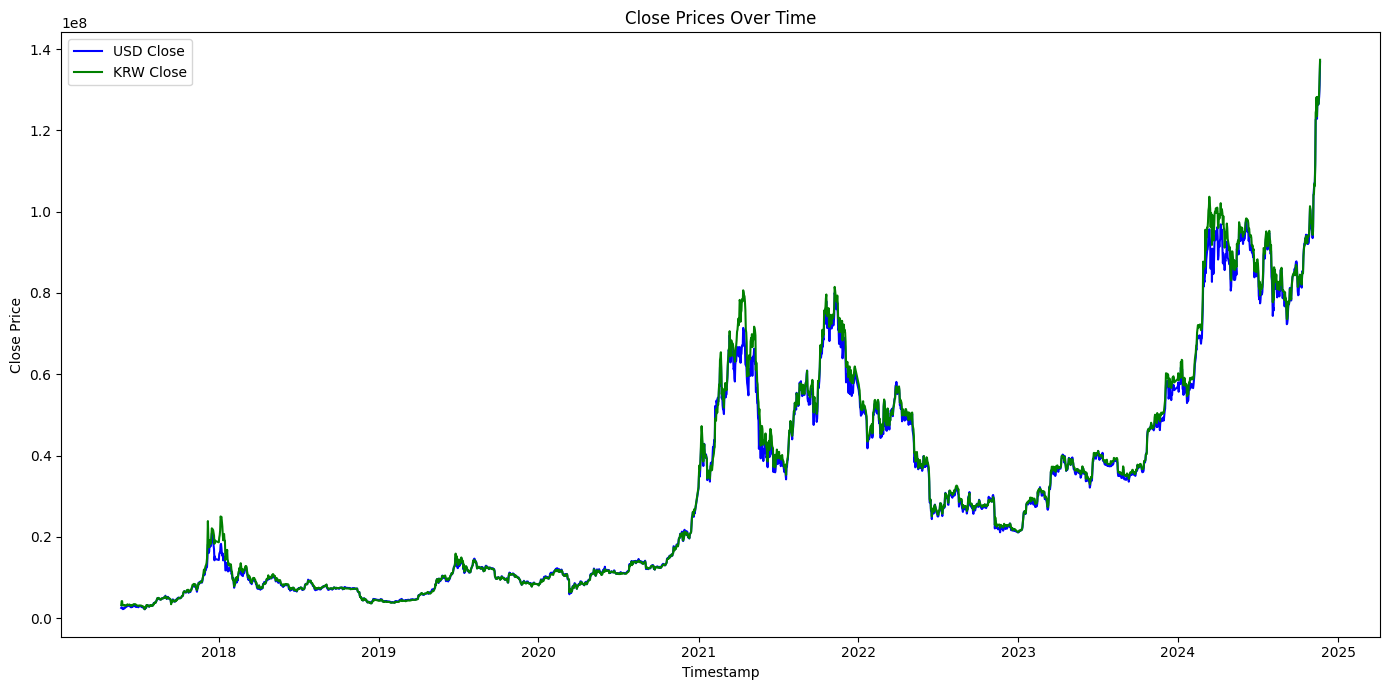

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 예제 (df_combined이 이미 존재한다고 가정)
# usd_close, krw_close: 시각화할 열
# timestamp: 시간 열

# 데이터프레임에서 필요한 열 추출
usd_close = df_combined['usd_close']
krw_close = df_combined['krw_close']
timestamps = pd.to_datetime(df_combined['timestamp'])  # timestamp를 datetime 형식으로 변환

# 시각화
plt.figure(figsize=(14, 7))

# USD Close 시각화
plt.plot(timestamps, usd_close, label='USD Close', color='blue')

# KRW Close 시각화
plt.plot(timestamps, krw_close, label='KRW Close', color='green')

# 그래프 설정
plt.title('Close Prices Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
# 열 이름 변경 처리
df_combined = df_combined.rename(columns={
    '비트코인_x': '비트코인',
    '업비트_x': '업비트',
    'bitcoin_x': 'bitcoin',
    'coinbase_x': 'coinbase'
})

In [33]:
from sklearn.preprocessing import MinMaxScaler

# 2) 정규화
# 가격 데이터 정규화
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler_price.fit_transform(df_combined[price_columns])

# 한국 트렌드 데이터 정규화
scaler_korea_trend = MinMaxScaler(feature_range=(0, 1))
scaled_korea_trends = scaler_korea_trend.fit_transform(df_combined[korea_trend_columns])

# 글로벌 트렌드 데이터 정규화
scaler_global_trend = MinMaxScaler(feature_range=(0, 1))
scaled_global_trends = scaler_global_trend.fit_transform(df_combined[global_trend_columns])

# USD와 KRW 타깃에 대해 별도의 스케일러 사용
scaler_usd = MinMaxScaler(feature_range=(0, 1))
scaled_usd_close = scaler_usd.fit_transform(df_combined[['usd_close']])

scaler_krw = MinMaxScaler(feature_range=(0, 1))
scaled_krw_close = scaler_krw.fit_transform(df_combined[['krw_close']])

# 타깃 변수 결합
scaled_targets = np.hstack([scaled_usd_close, scaled_krw_close])



In [34]:
# 3) 시퀀스 생성 함수
def create_sequences(prices, korea_trends, global_trends, targets, look_back=5, horizon=2):
    X_prices, X_korea, X_global, Y_usd, Y_krw = [], [], [], [], []
    for i in range(len(prices) - look_back - horizon + 1):
        X_prices.append(prices[i:i + look_back])
        X_korea.append(korea_trends[i:i + look_back])
        X_global.append(global_trends[i:i + look_back])
        Y_usd.append(targets[i + look_back + horizon - 1, 0])  # usd_close
        Y_krw.append(targets[i + look_back + horizon - 1, 1])  # krw_close
    return (np.array(X_prices), np.array(X_korea), np.array(X_global), 
            np.array(Y_usd), np.array(Y_krw))


# 시퀀스 생성
look_back = 7
X_prices, X_korea, X_global, y_usd, y_krw = create_sequences(
    scaled_prices, scaled_korea_trends, scaled_global_trends, scaled_targets, look_back)

# 데이터 크기 계산
train_size = int(len(X_prices) * 0.6)  # 60% 훈련 데이터
val_size = int(len(X_prices) * 0.2)    # 20% 검증 데이터
test_size = len(X_prices) - train_size - val_size  # 나머지 20% 테스트 데이터

# 훈련, 검증, 테스트 데이터 분리 (시간 순서 유지)
X_train_prices = X_prices[:train_size]
X_train_korea = X_korea[:train_size]
X_train_global = X_global[:train_size]
y_train_usd = y_usd[:train_size]
y_train_krw = y_krw[:train_size]

X_val_prices = X_prices[train_size:train_size + val_size]
X_val_korea = X_korea[train_size:train_size + val_size]
X_val_global = X_global[train_size:train_size + val_size]
y_val_usd = y_usd[train_size:train_size + val_size]
y_val_krw = y_krw[train_size:train_size + val_size]

X_test_prices = X_prices[train_size + val_size:]
X_test_korea = X_korea[train_size + val_size:]
X_test_global = X_global[train_size + val_size:]
y_test_usd = y_usd[train_size + val_size:]
y_test_krw = y_krw[train_size + val_size:]

# y_train, y_val, y_test 설정
y_train = [y_train_usd, y_train_krw]
y_val = [y_val_usd, y_val_krw]
y_test = [y_test_usd, y_test_krw]



In [35]:
from keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Dense, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt

# 4) 다중 입력 및 출력 모델 생성
price_input = Input(shape=(look_back, len(price_columns)), name='price_input')
korea_trend_input = Input(shape=(look_back, len(korea_trend_columns)), name='korea_trend_input')
global_trend_input = Input(shape=(look_back, len(global_trend_columns)), name='global_trend_input')

# Price CNN-LSTM
x_price = Conv1D(filters=64, kernel_size=2, activation='relu')(price_input)
x_price = MaxPooling1D(pool_size=2)(x_price)
x_price = LSTM(64, return_sequences=False)(x_price)

# Korea Trend LSTM
x_korea = LSTM(32, return_sequences=False)(korea_trend_input)

# Global Trend LSTM
x_global = LSTM(32, return_sequences=False)(global_trend_input)

# Concatenate Features
x = Concatenate()([x_price, x_korea, x_global])
x = Dense(64, activation='relu')(x)

# Multi-output layers
usd_output = Dense(1, name='usd_close')(x)
krw_output = Dense(1, name='krw_close')(x)

# 모델 생성
model = Model(inputs=[price_input, korea_trend_input, global_trend_input], outputs=[usd_output, krw_output])

# Huber 손실 함수 정의
huber_loss = tf.keras.losses.Huber(delta=1.0)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss={'usd_close': huber_loss, 'krw_close': huber_loss}, 
              metrics=['mape'])

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_trend.h5', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.98, patience=5, verbose=1)

# 모델 학습
history = model.fit(
    [X_train_prices, X_train_korea, X_train_global],  # 다중 입력
    {'usd_close': y_train[0], 'krw_close': y_train[1]},  # 다중 출력
    validation_data=(
        [X_val_prices, X_val_korea, X_val_global],  # 검증 데이터 입력
        {'usd_close': y_val[0], 'krw_close': y_val[1]}  # 검증 데이터 출력
    ),
    epochs=10000,
    batch_size=32,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)



Epoch 1/10000
51/51 [==============================] - ETA: 0s - loss: 0.0082 - usd_close_loss: 0.0041 - krw_close_loss: 0.0041 - usd_close_mape: 75721.7578 - krw_close_mape: 44585.4414
Epoch 1: val_loss improved from inf to 0.00066, saving model to best_model_trend.h5
51/51 [==============================] - 5s 33ms/step - loss: 0.0082 - usd_close_loss: 0.0041 - krw_close_loss: 0.0041 - usd_close_mape: 75721.7578 - krw_close_mape: 44585.4414 - val_loss: 6.6143e-04 - val_usd_close_loss: 3.2288e-04 - val_krw_close_loss: 3.3855e-04 - val_usd_close_mape: 9.0100 - val_krw_close_mape: 9.8243 - lr: 0.0010
Epoch 2/10000
 9/51 [====>.........................] - ETA: 0s - loss: 5.7763e-04 - usd_close_loss: 2.9634e-04 - krw_close_loss: 2.8129e-04 - usd_close_mape: 52.3740 - krw_close_mape: 41.4725

/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/51 [===========================>..] - ETA: 0s - loss: 4.7121e-04 - usd_close_loss: 2.3986e-04 - krw_close_loss: 2.3136e-04 - usd_close_mape: 5774.0913 - krw_close_mape: 2470.2327
Epoch 2: val_loss improved from 0.00066 to 0.00040, saving model to best_model_trend.h5
51/51 [==============================] - 1s 16ms/step - loss: 4.7259e-04 - usd_close_loss: 2.4208e-04 - krw_close_loss: 2.3051e-04 - usd_close_mape: 5516.4209 - krw_close_mape: 2360.4209 - val_loss: 3.9923e-04 - val_usd_close_loss: 2.3751e-04 - val_krw_close_loss: 1.6173e-04 - val_usd_close_mape: 7.1131 - val_krw_close_mape: 5.0027 - lr: 0.0010
Epoch 3/10000
51/51 [==============================] - ETA: 0s - loss: 3.5930e-04 - usd_close_loss: 1.9260e-04 - krw_close_loss: 1.6670e-04 - usd_close_mape: 11473.3818 - krw_close_mape: 6877.3667
Epoch 3: val_loss improved from 0.00040 to 0.00033, saving model to best_model_trend.h5
51/51 [==============================] - 1s 16ms/step - loss: 3.5930e-04 - usd_close_loss: 1.9260e

17/17 [==============================] - 0s 4ms/step


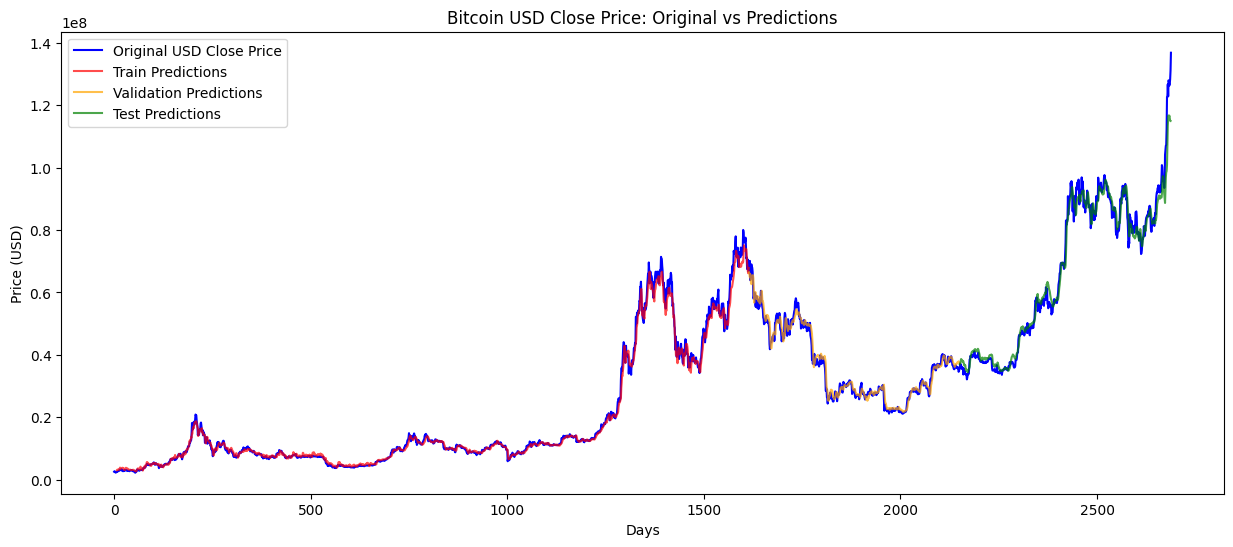

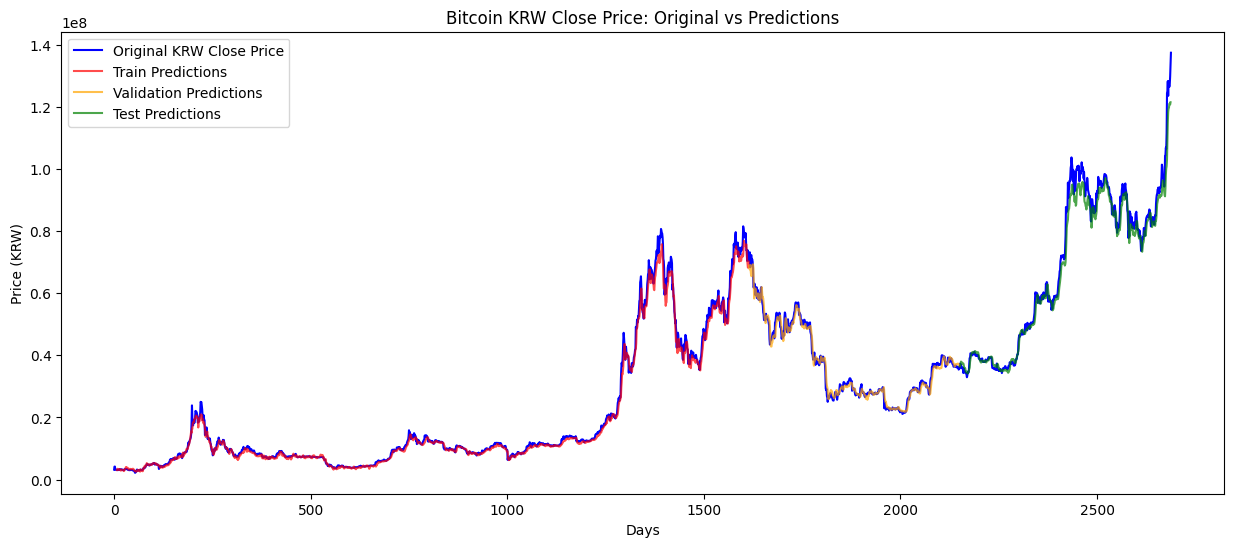

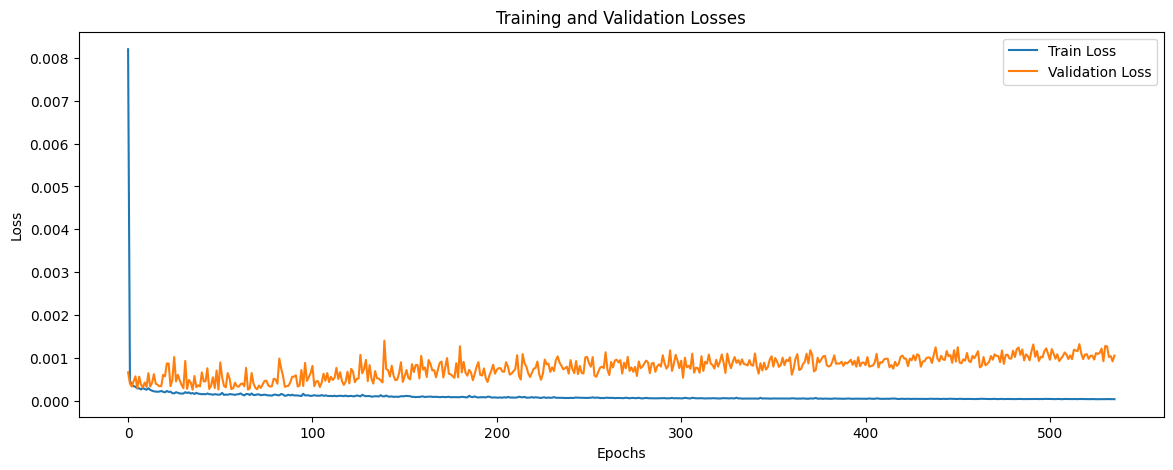

Test Loss (USD Close): 0.0005
Test Loss (KRW Close): 0.0005


In [36]:
# 테스트 데이터에 대한 손실 계산
test_loss = model.evaluate(
    [X_test_prices, X_test_korea, X_test_global],  # 테스트 입력 데이터
    {'usd_close': y_test[0], 'krw_close': y_test[1]},  # 테스트 출력 데이터
    verbose=1
)

# 훈련 데이터에 대한 예측 수행
train_predict = model.predict([X_train_prices, X_train_korea, X_train_global])

# 검증 데이터에 대한 예측 수행
val_predict = model.predict([X_val_prices, X_val_korea, X_val_global])

# 테스트 데이터에 대한 예측 수행
test_predict = model.predict([X_test_prices, X_test_korea, X_test_global])

# 예측값 역정규화

# 예측값 역정규화 (USD)
train_predict_usd = scaler_usd.inverse_transform(train_predict[0].reshape(-1, 1)).flatten()
val_predict_usd = scaler_usd.inverse_transform(val_predict[0].reshape(-1, 1)).flatten()
test_predict_usd = scaler_usd.inverse_transform(test_predict[0].reshape(-1, 1)).flatten()

# 예측값 역정규화 (KRW)
train_predict_krw = scaler_krw.inverse_transform(train_predict[1].reshape(-1, 1)).flatten()
val_predict_krw = scaler_krw.inverse_transform(val_predict[1].reshape(-1, 1)).flatten()
test_predict_krw = scaler_krw.inverse_transform(test_predict[1].reshape(-1, 1)).flatten()

# 원본 타깃값 역정규화 (USD)
y_train_usd_orig = scaler_usd.inverse_transform(y_train[0].reshape(-1, 1)).flatten()
y_val_usd_orig = scaler_usd.inverse_transform(y_val[0].reshape(-1, 1)).flatten()
y_test_usd_orig = scaler_usd.inverse_transform(y_test[0].reshape(-1, 1)).flatten()

# 원본 타깃값 역정규화 (KRW)
y_train_krw_orig = scaler_krw.inverse_transform(y_train[1].reshape(-1, 1)).flatten()
y_val_krw_orig = scaler_krw.inverse_transform(y_val[1].reshape(-1, 1)).flatten()
y_test_krw_orig = scaler_krw.inverse_transform(y_test[1].reshape(-1, 1)).flatten()

# 인덱스 계산
train_indices = range(look_back, look_back + len(train_predict_usd))
val_indices = range(look_back + len(train_predict_usd), look_back + len(train_predict_usd) + len(val_predict_usd))
test_indices = range(look_back + len(train_predict_usd) + len(val_predict_usd), look_back + len(train_predict_usd) + len(val_predict_usd) + len(test_predict_usd))

# USD 가격 시각화
plt.figure(figsize=(15, 6))
plt.plot(original_usd_close, label='Original USD Close Price', color='blue')
plt.plot(train_indices, train_predict_usd, label='Train Predictions', color='red', alpha=0.7)
plt.plot(val_indices, val_predict_usd, label='Validation Predictions', color='orange', alpha=0.7)
plt.plot(test_indices, test_predict_usd, label='Test Predictions', color='green', alpha=0.7)
plt.title('Bitcoin USD Close Price: Original vs Predictions')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# KRW 가격 시각화
plt.figure(figsize=(15, 6))
plt.plot(original_krw_close, label='Original KRW Close Price', color='blue')
plt.plot(train_indices, train_predict_krw, label='Train Predictions', color='red', alpha=0.7)
plt.plot(val_indices, val_predict_krw, label='Validation Predictions', color='orange', alpha=0.7)
plt.plot(test_indices, test_predict_krw, label='Test Predictions', color='green', alpha=0.7)
plt.title('Bitcoin KRW Close Price: Original vs Predictions')
plt.xlabel('Days')
plt.ylabel('Price (KRW)')
plt.legend()
plt.show()

# 손실 곡선 시각화
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 테스트 데이터의 개별 출력 손실 확인 (USD Close와 KRW Close)
print(f"Test Loss (USD Close): {test_loss[1]:.4f}")
print(f"Test Loss (KRW Close): {test_loss[2]:.4f}")
